In [1]:
## ライブラリのインポート
import matplotlib.pyplot as plt
import japanize_matplotlib
import numpy as np
import time
import random
from qulacs import QuantumState
from qulacs.state import inner_product
from qulacs import QuantumCircuit
from qulacs.gate import to_matrix_gate
from qulacs import QuantumState
from qulacs.gate import Identity, X,Y,Z #パウリ演算子
from qulacs.gate import H
from qulacs.gate import RX,RY,RZ #パウリ演算子についての回転演算

from fractions import Fraction

In [2]:
global_nqubits = 5

## 理想的な回路作成

In [3]:
# 係数の絶対値の分布をプロットする関数
def show_distribution(state, nqubits):
    plt.bar([i for i in range(pow(2, nqubits))], abs(state.get_vector()))
    plt.xlabel('量子ビット')
    plt.ylabel('確率')
    plt.show()

### 動作の確認
まずは5量子ビットのアルゴリズムを実装し、動作を確認する。

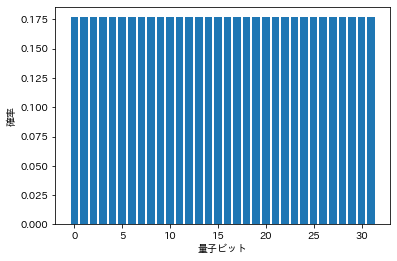

In [4]:
nqubits = 5
state = QuantumState(nqubits)
state.set_zero_state()

def make_Hadamard(nqubits):
    Hadamard = QuantumCircuit(nqubits)
    for i in range(nqubits):
        Hadamard.add_gate(H(i))
    return  Hadamard

Hadamard = make_Hadamard(nqubits)
Hadamard.update_quantum_state(state)

show_distribution(state, nqubits)

In [5]:
# オラクルU_wの作成
def make_U_w(nqubits):
    U_w = QuantumCircuit(nqubits)
    CnZ = to_matrix_gate(Z(nqubits-1))
    # i-th qubitが全て1の場合だけゲートを作用
    for i in range(nqubits-1):
        control_index = i
        control_with_value = 1
        CnZ.add_control_qubit(control_index, control_with_value)
    U_w.add_gate(CnZ)
    return U_w

In [6]:
fuga = state.copy()
U_w = make_U_w(nqubits)
U_w.update_quantum_state(fuga)
print(fuga.get_vector())

[ 0.1767767+0.j  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j
  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j
  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j
  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j
  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j
  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j
  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j
  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j -0.1767767+0.j]


In [7]:
# 反転U_sを作る
def make_U_s(nqubits):
    U_s = QuantumCircuit(nqubits)
    for i in range(nqubits):
        U_s.add_gate(H(i))

    ## 2|0><0| - I の実装
    U_s.add_gate(to_matrix_gate(RZ(nqubits-1, 2*np.pi))) ## まず、位相(-1)を全ての状態に付与する。ゲート行列はarrary([[-1,0],[0,-1]])
    U_s.add_gate( X(nqubits-1) )
    ## 全てのi-th qubitが0の場合だけZゲートを作用させる
    CnZ = to_matrix_gate(Z(nqubits-1))
    for i in range(nqubits-1):
        control_index = i
        control_with_value = 0
        CnZ.add_control_qubit(control_index, control_with_value)
    U_s.add_gate( CnZ )
    U_s.add_gate( X(nqubits-1) )

    for i in range(nqubits):
        U_s.add_gate(H(i))

    return U_s

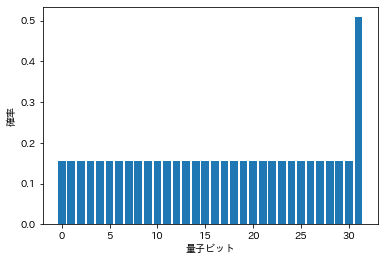

In [8]:
## 初期状態の準備
state = QuantumState(nqubits)
state.set_zero_state()
Hadamard.update_quantum_state(state)

## U_s U_w を作用
U_s = make_U_s(nqubits)
U_w.update_quantum_state(state)
U_s.update_quantum_state(state)
show_distribution(state,nqubits)

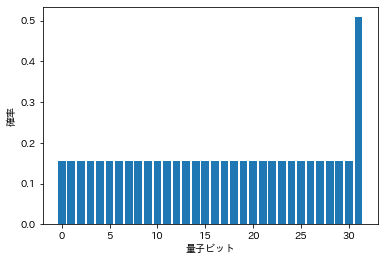

0.5082329989778305


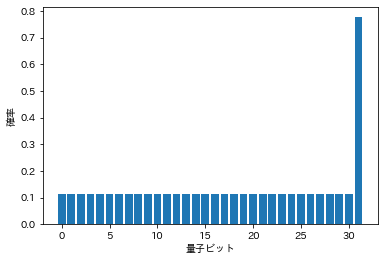

0.7761601777867947


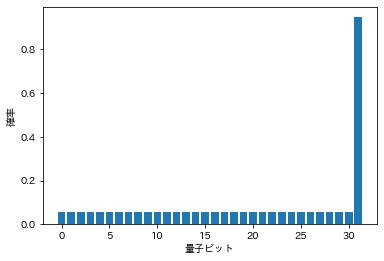

0.9470673343724091


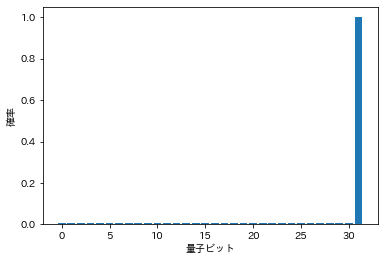

0.9995910741614723


In [9]:
# 何回か繰り返す
## 内積を評価するために 解状態 |1...1> を作っておく
target_state = QuantumState(nqubits)
target_state.set_computational_basis(2**nqubits-1) ## 2**n_qubits-1 は 2進数で 1...1

## グローバーのアルゴリズムの実行
state = QuantumState(nqubits)
state.set_zero_state()

Hadamard.update_quantum_state(state)

avg_result = []
for i in range(4):
    U_w.update_quantum_state(state)
    U_s.update_quantum_state(state)
    show_distribution(state,nqubits)
    fuga = np.linalg.norm(inner_product(state, target_state))
    avg_result.append(fuga)
    print(fuga)

0.5082329989778305
0.7761601777867947
0.9470673343724091
0.9995910741614723
0.9271659296803515
0.738845043989187
0.4581685277993745
0.1202209456346408
0.23275425473442243
0.5566351732616823


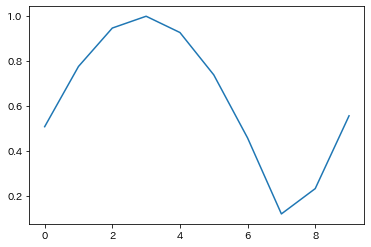

In [10]:
## 初期状態の準備
state = QuantumState(nqubits)
state.set_zero_state()
Hadamard.update_quantum_state(state)

avg_result = []
times = 10
for i in range(times):
    U_w.update_quantum_state(state)
    U_s.update_quantum_state(state)
    fuga = np.linalg.norm(inner_product(state, target_state))
    avg_result.append(fuga)
    print(fuga)

plt.plot(avg_result)

In [11]:
# グローバーのアルゴリズム
def grover(nqubits, operate_times):
    state = QuantumState(nqubits)
    state.set_zero_state()

    # 内積を評価するために 解状態 |1...1> を作っておく
    target_state = QuantumState(nqubits)
    target_state.set_computational_basis(2 ** nqubits - 1) # 2**n_qubits-1 は 2進数で 1...1

    # グローバーのアルゴリズムの実行
    Hadamard = make_Hadamard(nqubits)
    U_w = make_U_w(nqubits)
    U_s = make_U_s(nqubits)

    result = []

    state = QuantumState(nqubits)
    state.set_zero_state()
    Hadamard.update_quantum_state(state)
    for k in range(operate_times):
        U_w.update_quantum_state(state)
        U_s.update_quantum_state(state)
        fuga = np.linalg.norm(inner_product(state, target_state))
        result.append(fuga)
        print(fuga)


    max_k = np.argmax(result)
    print(f'maximal probability {result[max_k]:5e} is obtained at k = {max_k + 1}')

    plt.plot(result, "o-")
    plt.xlabel('オラクルの試行回数k')
    plt.ylabel('確率')
    plt.show()

0.5082329989778305
0.7761601777867947
0.9470673343724091
0.9995910741614723
0.9271659296803515
0.738845043989187
0.4581685277993745
0.1202209456346408
0.23275425473442243
0.5566351732616823
maximal probability 9.995911e-01 is obtained at k = 4


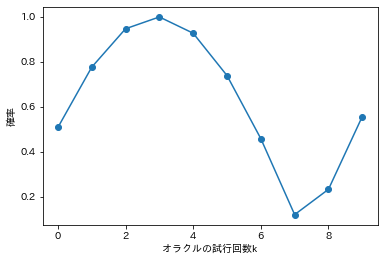

In [12]:
grover(5, 10)

## ノイズを入れてみる。
http://docs.qulacs.org/ja/latest/guide/2.0_python_advanced.html#id37

In [13]:
from qulacs.gate import DephasingNoise
from qulacs.gate import Probabilistic

[こちらを参考にして](https://docs.qulacs.org/ja/latest/guide/2.0_python_advanced.html?highlight=distribution#id39)、確率pでパウリ演算子Iを作用させる


In [14]:
def make_noisy_Hadamard(nqubits, dephasing_rate):
    Hadamard = QuantumCircuit(nqubits)
    # dphe_gate = DephasingNoise(0, dephasing_rate)
    # distribution = [1 - dephasing_rate, dephasing_rate]
    distribution = [1 - float(Fraction(f'{dephasing_rate}')), dephasing_rate]
    float(Fraction('0.1'))
    for i in range(nqubits):
        gate_list = [H(i), Identity(i)]
        gate = Probabilistic(distribution, gate_list)
        # Hadamard.add_gate(H(i))
        Hadamard.add_gate(gate)
    return  Hadamard

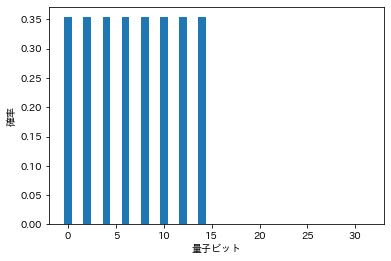

In [15]:
nqubits = 5
dephasing_rate = 0.5
state = QuantumState(nqubits)
state.set_zero_state()

Hadamard = make_noisy_Hadamard(nqubits, dephasing_rate)
Hadamard.update_quantum_state(state)

show_distribution(state, nqubits)

In [16]:
fuga = state.copy()
U_w = make_U_w(nqubits)
U_w.update_quantum_state(fuga)
print(fuga.get_vector())

[0.35355339+0.j 0.        +0.j 0.35355339+0.j 0.        +0.j
 0.35355339+0.j 0.        +0.j 0.35355339+0.j 0.        +0.j
 0.35355339+0.j 0.        +0.j 0.35355339+0.j 0.        +0.j
 0.35355339+0.j 0.        +0.j 0.35355339+0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j]


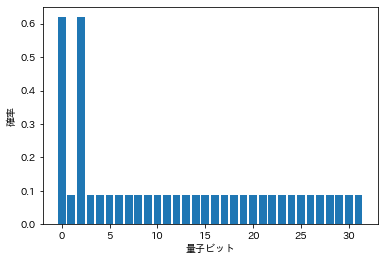

In [17]:
## 初期状態の準備
state = QuantumState(nqubits)
state.set_zero_state()
Hadamard.update_quantum_state(state)

## U_s U_w を作用
U_s = make_U_s(nqubits)
U_w.update_quantum_state(state)
U_s.update_quantum_state(state)
show_distribution(state,nqubits)

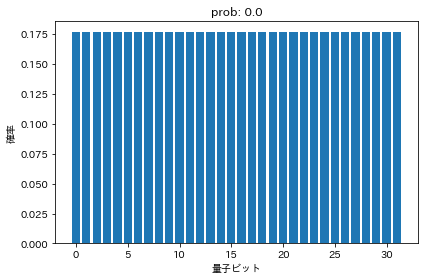

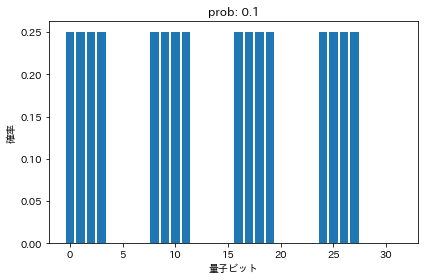

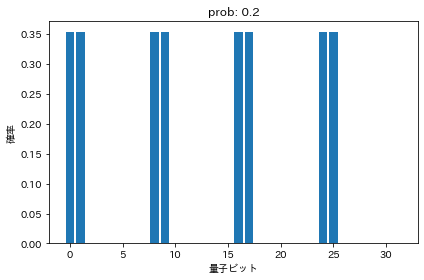

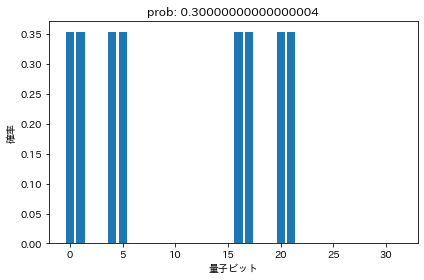

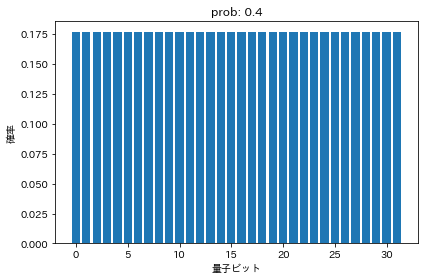

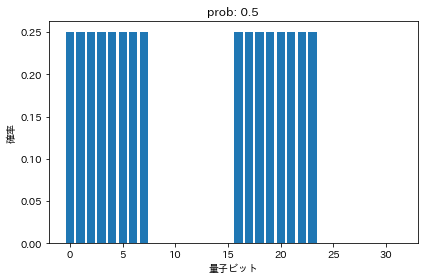

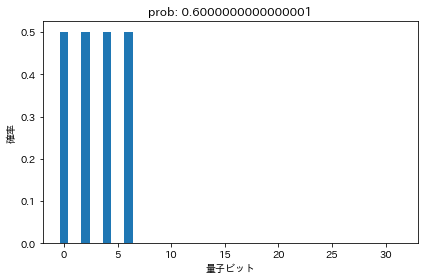

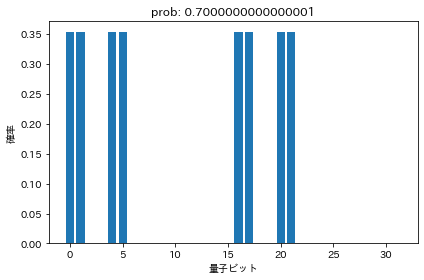

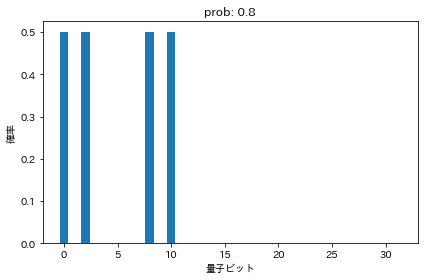

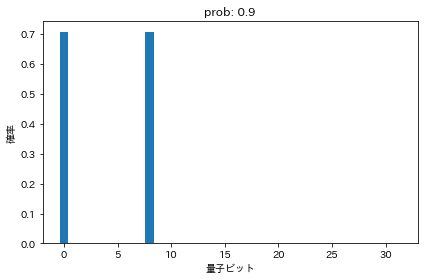

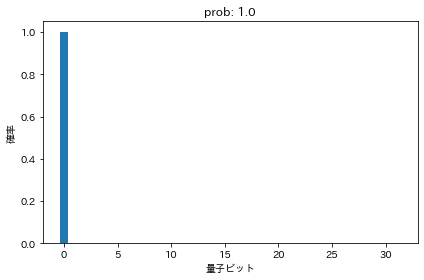

In [18]:
for i in range(0, 11):
    nqubits = 5
    dephasing_rate = i * 0.1 # p = dephasing_rateとして計算
    state = QuantumState(nqubits)
    state.set_zero_state()

    Hadamard = make_noisy_Hadamard(nqubits, dephasing_rate)
    Hadamard.update_quantum_state(state)

    plt.subplots(1, 1, tight_layout = True)
    plt.subplots_adjust(wspace=0.5, hspace=0.5)
    plt.title(f'prob: {dephasing_rate}')
    plt.xlabel('量子ビット数')
    plt.ylabel('確率')
    show_distribution(state, nqubits)


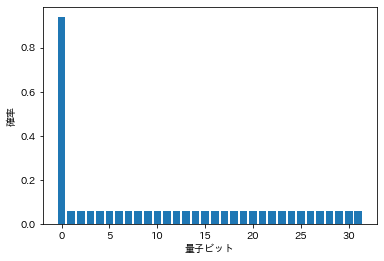

0.06249999999999995


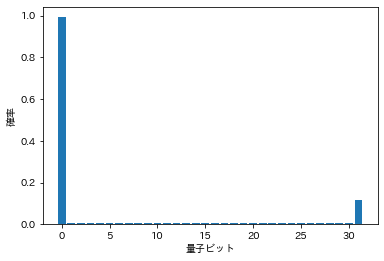

0.11718749999999978


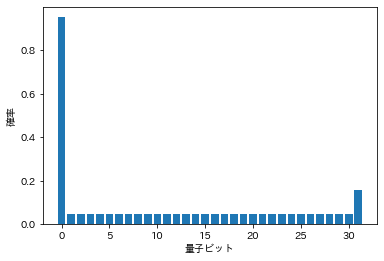

0.15722656249999956


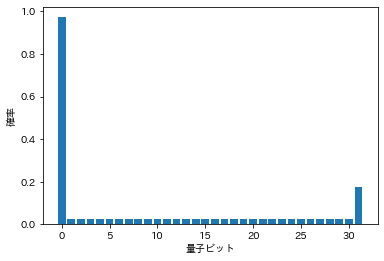

0.17761230468749936


In [19]:
# 何回か繰り返す
## 内積を評価するために 解状態 |1...1> を作っておく
target_state = QuantumState(nqubits)
target_state.set_computational_basis(2**nqubits-1) ## 2**n_qubits-1 は 2進数で 1...1

## グローバーのアルゴリズムの実行
state = QuantumState(nqubits)
state.set_zero_state()

Hadamard.update_quantum_state(state)

avg_result = []
for i in range(4):
    U_w.update_quantum_state(state)
    U_s.update_quantum_state(state)
    show_distribution(state,nqubits)
    fuga = np.linalg.norm(inner_product(state, target_state))
    avg_result.append(fuga)
    print(fuga)

0.06249999999999995
0.11718749999999978
0.15722656249999956
0.17761230468749936
0.17579650878906175
0.15200614929199144
0.10921502113342227
0.052772015333175396
0.010267492383718288
0.0720235635526471


Text(0, 0.5, '確率')

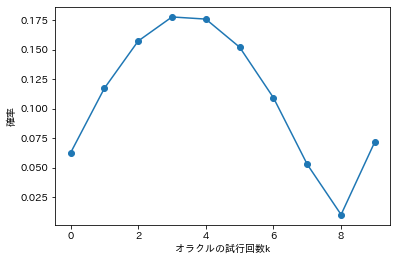

In [20]:
Hadamard = make_noisy_Hadamard(nqubits, dephasing_rate)
## 初期状態の準備
state = QuantumState(nqubits)
state.set_zero_state()
Hadamard.update_quantum_state(state)

avg_result = []
times = 10
for i in range(times):
    U_w.update_quantum_state(state)
    U_s.update_quantum_state(state)
    fuga = np.linalg.norm(inner_product(state, target_state))
    avg_result.append(fuga)
    print(fuga)

plt.plot(avg_result, "-o")
plt.xlabel('オラクルの試行回数k')
plt.ylabel('確率')

In [21]:
max_result = []
# グローバーのアルゴリズム
def noisy_grover(nqubits, operate_times, dephasing_rate):
    state = QuantumState(nqubits)
    state.set_zero_state()

    # 内積を評価するために 解状態 |1...1> を作っておく
    target_state = QuantumState(nqubits)
    target_state.set_computational_basis(2 ** nqubits - 1) # 2**n_qubits-1 は 2進数で 1...1

    # グローバーのアルゴリズムの実行
    # Hadamard = make_Hadamard(nqubits)
    Noisy_Hadamard = make_noisy_Hadamard(nqubits, dephasing_rate)
    U_w = make_U_w(nqubits)
    U_s = make_U_s(nqubits)

    result = []

    state = QuantumState(nqubits)
    state.set_zero_state()
    Noisy_Hadamard.update_quantum_state(state)
    for k in range(operate_times):
        U_w.update_quantum_state(state)
        U_s.update_quantum_state(state)
        fuga = np.linalg.norm(inner_product(state, target_state))
        result.append(fuga)
        # print(fuga)


    max_k = np.argmax(result)
    max_result.append(result[max_k])

    # print(f'maximal probability {result[max_k]:5e} is obtained at k = {max_k + 1}')

    plt.plot(result, "o-")
    plt.xlabel('オラクルの回数k')
    plt.ylabel('確率')

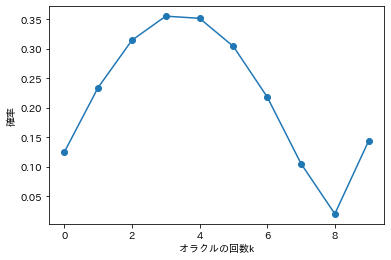

In [22]:
noisy_grover(5, 10, 0.5)

0.0
0.1
0.2
0.30000000000000004
0.4
0.5
0.6000000000000001
0.7000000000000001
0.8
0.9
1.0


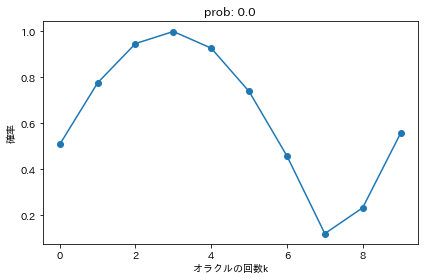

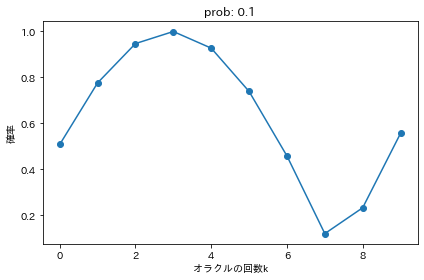

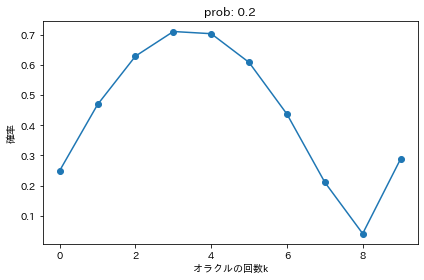

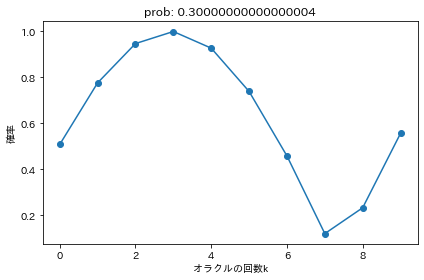

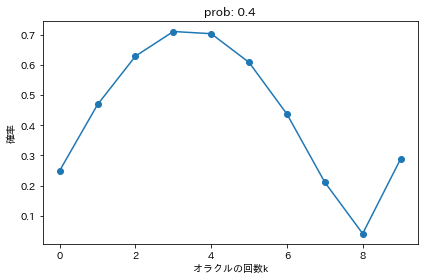

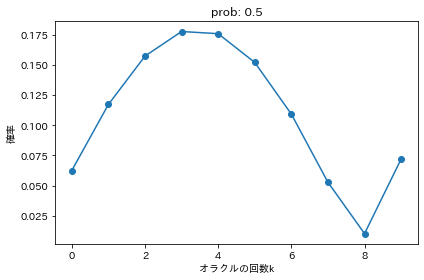

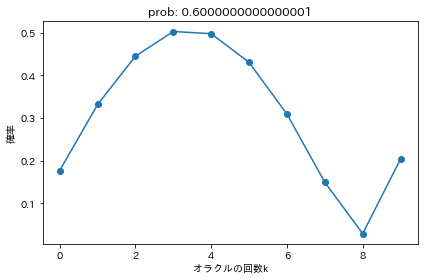

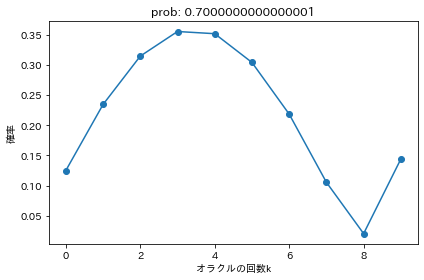

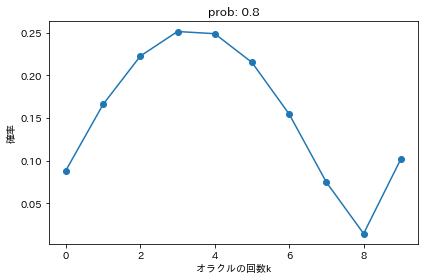

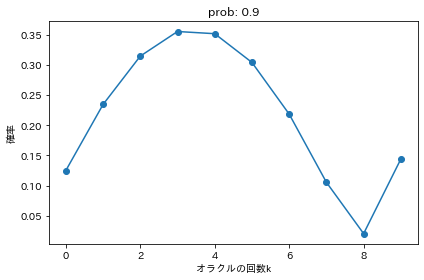

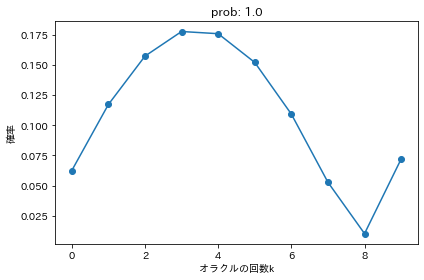

In [23]:
max_result = []
for i in range(0, 11):
    x = i * 0.1
    print(x)
    plt.subplots(1, 1, tight_layout = True)
    plt.subplots_adjust(wspace=0.5, hspace=0.5)
    plt.title(f'prob: {x}')
    noisy_grover(5, 10, x)

In [24]:
max_result = []
def noisy_I_grover(nqubits, times):
    for i in range(0, 11):
        x = i * 0.1
        noisy_grover(5, 10, x)
    # print(max_result)
    # plt.plot(max_result)

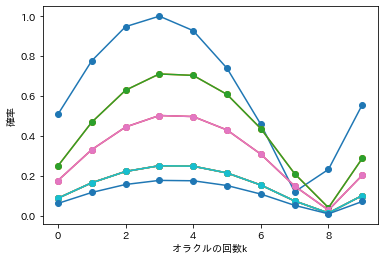

In [25]:
noisy_I_grover(5, 10)

[0.9995910741614723, 0.7104492187499972, 0.7104492187499972, 0.5023634602668081, 0.2511817301334041, 0.2511817301334041, 0.5023634602668081, 0.2511817301334041, 0.25118173013340406, 0.2511817301334041, 0.17761230468749936]


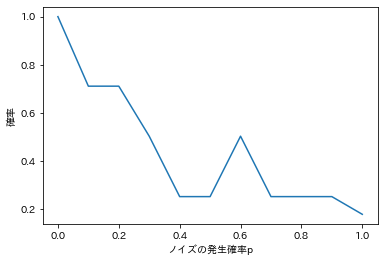

In [26]:
print(max_result)
plt.plot(max_result)
plt.xlabel('ノイズの発生確率p')
plt.xticks(np.arange(0, 11, 2), [i/10 for i in range(0, 11, 2) ])
plt.ylabel('確率')

plt.show()


In [27]:
max_result = []
# グローバーのアルゴリズム
def noisy_grover_1(nqubits, operate_times, dephasing_rate):
    state = QuantumState(nqubits)
    state.set_zero_state()

    # 内積を評価するために 解状態 |1...1> を作っておく
    target_state = QuantumState(nqubits)
    target_state.set_computational_basis(2 ** nqubits - 1) # 2**n_qubits-1 は 2進数で 1...1

    # グローバーのアルゴリズムの実行
    # Hadamard = make_Hadamard(nqubits)
    Noisy_Hadamard = make_noisy_Hadamard(nqubits, dephasing_rate)
    U_w = make_U_w(nqubits)
    U_s = make_U_s(nqubits)

    result = []

    state = QuantumState(nqubits)
    state.set_zero_state()
    Noisy_Hadamard.update_quantum_state(state)
    for k in range(operate_times):
        U_w.update_quantum_state(state)
        U_s.update_quantum_state(state)
        fuga = np.linalg.norm(inner_product(state, target_state))
        result.append(fuga)
        # print(fuga)


    max_k = np.argmax(result)
    max_result.append(result[max_k])

    # print(f'maximal probability {result[max_k]:5e} is obtained at k = {max_k + 1}')

    plt.plot(result, "o-")
    plt.xlabel('オラクルの回数k')
    plt.ylabel('確率')


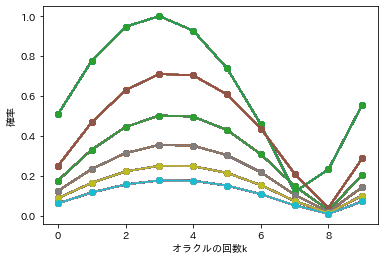

In [28]:
sample_data_times = 100 # サンプルを集める試行回数
nqubits = 5
total_result = []
for i in range(sample_data_times):
    max_result = []
    noisy_I_grover(global_nqubits, 10)
    # print(f'max result:{max_result}')
    total_result.append(max_result)

[0.9995910741614723, 0.9995910741614723, 0.9995910741614723, 0.9995910741614723, 0.9995910741614723]
[0.9995910741614723, 0.9995910741614723, 0.7104492187499972, 0.502363460266808, 0.9995910741614723]
[0.9995910741614723, 0.5023634602668081, 0.502363460266808, 0.7104492187499972, 0.7104492187499972]
[0.7104492187499972, 0.502363460266808, 0.7104492187499972, 0.7104492187499974, 0.9995910741614723]
[0.7104492187499972, 0.7104492187499974, 0.7104492187499972, 0.502363460266808, 0.3552246093749988]
[0.9995910741614723, 0.502363460266808, 0.3552246093749988, 0.5023634602668081, 0.3552246093749988]
[0.5023634602668082, 0.17761230468749936, 0.3552246093749987, 0.2511817301334041, 0.2511817301334041]
[0.5023634602668081, 0.3552246093749988, 0.502363460266808, 0.3552246093749987, 0.3552246093749987]
[0.3552246093749988, 0.2511817301334041, 0.17761230468749936, 0.17761230468749936, 0.25118173013340406]
[0.17761230468749936, 0.17761230468749936, 0.2511817301334041, 0.25118173013340406, 0.2511817

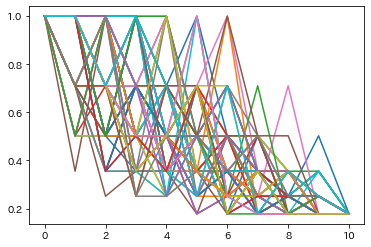

In [29]:
for j in total_result:
    plt.plot(j)

result = []
for i in range(10 + 1):
    hoge = []
    for j in range(nqubits):
        tmp = total_result[j][i]
        hoge.append(tmp)
    print(hoge)
    result.append(hoge)

[[0.9995910741614723, 0.9995910741614723, 0.9995910741614723, 0.9995910741614723, 0.9995910741614723], [0.9995910741614723, 0.9995910741614723, 0.7104492187499972, 0.502363460266808, 0.9995910741614723], [0.9995910741614723, 0.5023634602668081, 0.502363460266808, 0.7104492187499972, 0.7104492187499972], [0.7104492187499972, 0.502363460266808, 0.7104492187499972, 0.7104492187499974, 0.9995910741614723], [0.7104492187499972, 0.7104492187499974, 0.7104492187499972, 0.502363460266808, 0.3552246093749988], [0.9995910741614723, 0.502363460266808, 0.3552246093749988, 0.5023634602668081, 0.3552246093749988], [0.5023634602668082, 0.17761230468749936, 0.3552246093749987, 0.2511817301334041, 0.2511817301334041], [0.5023634602668081, 0.3552246093749988, 0.502363460266808, 0.3552246093749987, 0.3552246093749987], [0.3552246093749988, 0.2511817301334041, 0.17761230468749936, 0.17761230468749936, 0.25118173013340406], [0.17761230468749936, 0.17761230468749936, 0.2511817301334041, 0.25118173013340406,

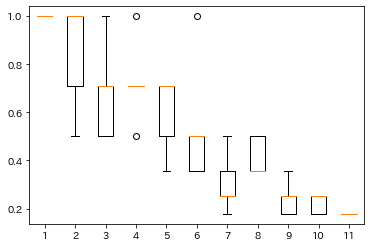

In [30]:
boxplot_result = result
print(boxplot_result)
plt.boxplot(boxplot_result)
plt.show()

平均結果:[0.9995910741614724, 0.8423171803002445, 0.6850432864390166, 0.7266604381356544, 0.5977871451783597, 0.5429534426890171, 0.3075127669192229, 0.41408014973172247, 0.24256253580336112, 0.2217539599550422, 0.17761230468749936]


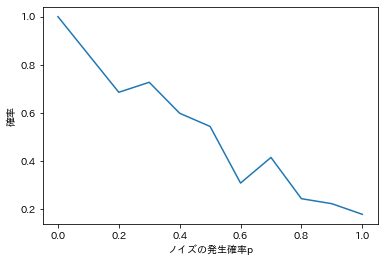

In [31]:
avg_result = []
scores = result

for score in scores:
    avg = np.mean(score)
    avg_result.append(avg)
print(f'平均結果:{avg_result}')
plt.plot(avg_result)
# plt.xlabel('オラクルの回数k')
# plt.ylabel('確率')
plt.xlabel('ノイズの発生確率p')
plt.xticks(np.arange(0, 11, 2), [i/10 for i in range(0, 11, 2) ])
plt.ylabel('確率')
plt.show()

分散：[1.232595164407831e-32, 0.04143258482376157, 0.03339501426697759, 0.025117735452892996, 0.02120409837636782, 0.056459449907545846, 0.012692742821461095, 0.005195961946022903, 0.00425567777745338, 0.0012989904865057277, 0.0]


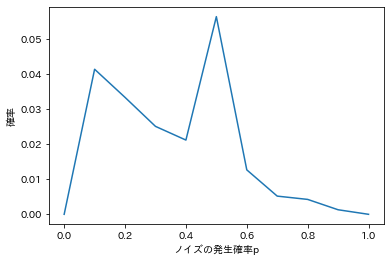

In [32]:
# 分散
variance = []
scores = result
for score in scores:
    v = np.var(score)
    variance.append(v)

print(f'分散：{variance}')

plt.plot(variance)
# plt.xlabel('オラクルの回数k')
# plt.ylabel('確率')
plt.xlabel('ノイズの発生確率p')
plt.xticks(np.arange(0, 11, 2), [i/10 for i in range(0, 11, 2) ])
plt.ylabel('確率')
plt.show()

標準偏差：[0.29401063010041906, 0.29401063010041906, 0.29401063010041906, 0.29401063010041906, 0.29401063010041906, 0.29401063010041906, 0.29401063010041906, 0.29401063010041906, 0.29401063010041906, 0.29401063010041906, 0.29401063010041906]


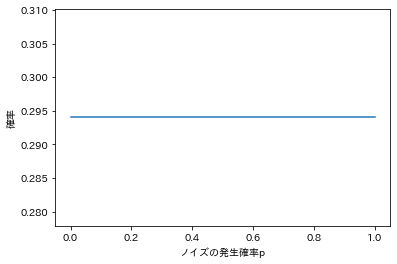

In [33]:
# 標準偏差
scores = result
standard = []
for score in scores:
    std = np.std(scores)
    standard.append(std)

print(f'標準偏差：{standard}')
plt.plot(standard)
# plt.xlabel('オラクルの回数k')
# plt.ylabel('確率')
plt.xlabel('ノイズの発生確率p')
plt.xticks(np.arange(0, 11, 2), [i/10 for i in range(0, 11, 2) ])
plt.ylabel('確率')
plt.show()

## p = 0.0, 1.0の特別な場合、どのようなことが発生するか

### p=0の時

In [34]:

nqubits = 5
dephasing_rate = 0


In [35]:
max_result = []
# グローバーのアルゴリズム
def noisy_grover(nqubits, operate_times, dephasing_rate):
    state = QuantumState(nqubits)
    state.set_zero_state()

    # 内積を評価するために 解状態 |1...1> を作っておく
    target_state = QuantumState(nqubits)
    target_state.set_computational_basis(2 ** nqubits - 1) # 2**n_qubits-1 は 2進数で 1...1

    # グローバーのアルゴリズムの実行
    Noisy_Hadamard = make_noisy_Hadamard(nqubits, dephasing_rate)
    U_w = make_U_w(nqubits)
    U_s = make_U_s(nqubits)

    result = []

    state = QuantumState(nqubits)
    state.set_zero_state()
    Noisy_Hadamard.update_quantum_state(state)
    print(f'確率p = {dephasing_rate}でHadamardが作用されない')
    print(f'確率:{np.linalg.norm(inner_product(state, target_state))}')
    show_distribution(state, nqubits)
    for k in range(operate_times):
        print(f'{k + 1}回目')
        U_w.update_quantum_state(state)
        U_s.update_quantum_state(state)
        fuga = np.linalg.norm(inner_product(state, target_state))
        print(f'確率：{fuga}')
        result.append(fuga)
        show_distribution(state, nqubits)


    max_k = np.argmax(result)
    max_result.append(result[max_k])

    print(f'maximal probability {result[max_k]:5e} is obtained at k = {max_k + 1}')

    plt.plot(result, "o-")
    plt.xlabel('オラクルの回数k')
    plt.ylabel('確率')


In [36]:
max_result = []
# グローバーのアルゴリズム
def noisy_grover_1(nqubits, operate_times, dephasing_rate):
    state = QuantumState(nqubits)
    state.set_zero_state()

    # 内積を評価するために 解状態 |1...1> を作っておく
    target_state = QuantumState(nqubits)
    target_state.set_computational_basis(2 ** nqubits - 1) # 2**n_qubits-1 は 2進数で 1...1

    # グローバーのアルゴリズムの実行
    Noisy_Hadamard = make_noisy_Hadamard(nqubits, dephasing_rate)
    U_w = make_U_w(nqubits)
    U_s = make_U_s(nqubits)

    result = []

    state = QuantumState(nqubits)
    state.set_zero_state()
    Noisy_Hadamard.update_quantum_state(state)
    # print(f'確率p = {dephasing_rate}でHadamardが作用されない')
    # print(f'確率:{np.linalg.norm(inner_product(state, target_state))}')
    # show_distribution(state, nqubits)
    for k in range(operate_times):
        # print(f'{k + 1}回目')
        U_w.update_quantum_state(state)
        U_s.update_quantum_state(state)
        fuga = np.linalg.norm(inner_product(state, target_state))
        # print(f'確率：{fuga}')
        result.append(fuga)
        # show_distribution(state, nqubits)


    max_k = np.argmax(result)
    max_result.append(result[max_k])

    # print(f'maximal probability {result[max_k]:5e} is obtained at k = {max_k + 1}')

    plt.plot(result, "o-")
    plt.xlabel('オラクルの回数k')
    plt.ylabel('確率')


確率p = 0.0でHadamardが作用されない
確率:0.1767766952966368


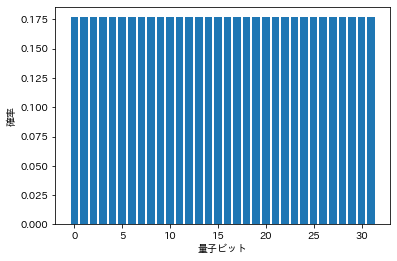

1回目
確率：0.5082329989778305


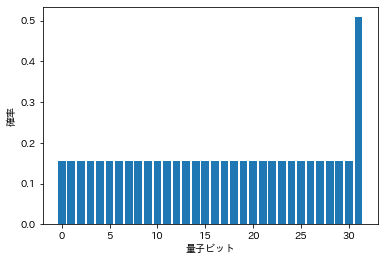

2回目
確率：0.7761601777867947


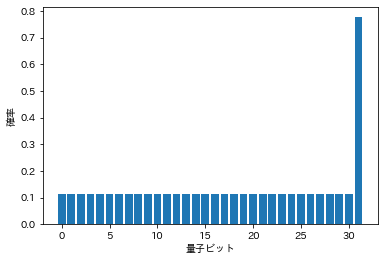

3回目
確率：0.9470673343724091


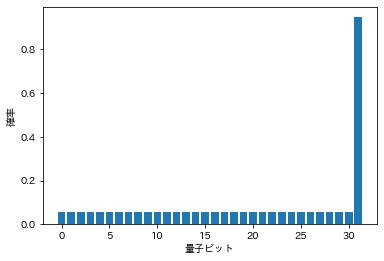

4回目
確率：0.9995910741614723


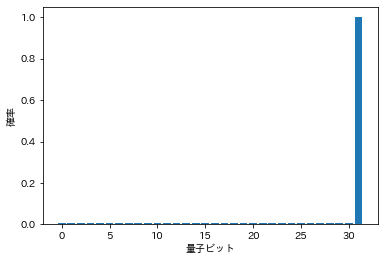

5回目
確率：0.9271659296803515


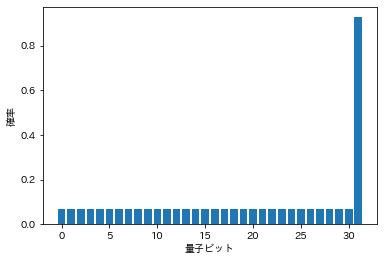

6回目
確率：0.738845043989187


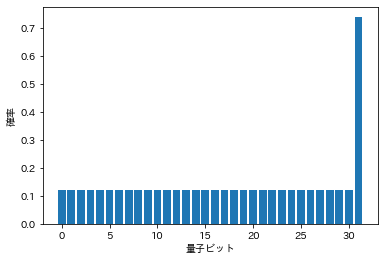

7回目
確率：0.4581685277993745


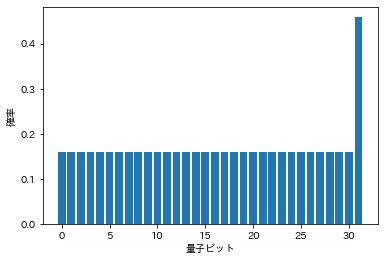

8回目
確率：0.1202209456346408


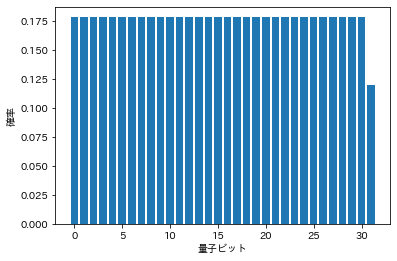

9回目
確率：0.23275425473442243


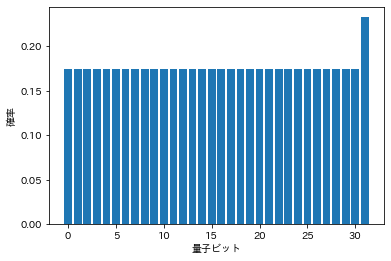

10回目
確率：0.5566351732616823


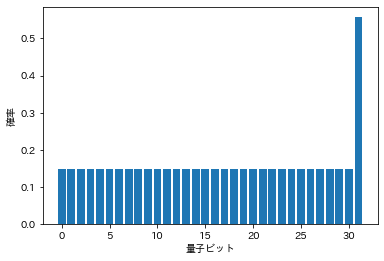

maximal probability 9.995911e-01 is obtained at k = 4
max result:[0.9995910741614723]


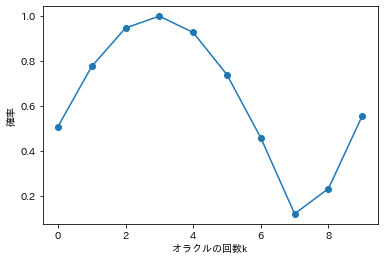

In [37]:
max_result = []
noisy_grover(5, 10, 0.0)
print(f'max result:{max_result}')

#### 試行回数を増やす

total result: [[0.9995910741614723], [0.9995910741614723], [0.9995910741614723], [0.9995910741614723], [0.9995910741614723], [0.9995910741614723], [0.9995910741614723], [0.9995910741614723], [0.9995910741614723], [0.9995910741614723], [0.9995910741614723], [0.9995910741614723], [0.9995910741614723], [0.9995910741614723], [0.9995910741614723], [0.9995910741614723], [0.9995910741614723], [0.9995910741614723], [0.9995910741614723], [0.9995910741614723], [0.9995910741614723], [0.9995910741614723], [0.9995910741614723], [0.9995910741614723], [0.9995910741614723], [0.9995910741614723], [0.9995910741614723], [0.9995910741614723], [0.9995910741614723], [0.9995910741614723], [0.9995910741614723], [0.9995910741614723], [0.9995910741614723], [0.9995910741614723], [0.9995910741614723], [0.9995910741614723], [0.9995910741614723], [0.9995910741614723], [0.9995910741614723], [0.9995910741614723], [0.9995910741614723], [0.9995910741614723], [0.9995910741614723], [0.9995910741614723], [0.99959107416147

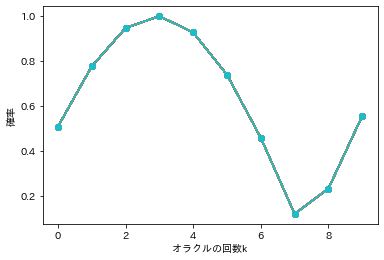

In [38]:
sample_data_times = 100 # サンプルを集める試行回数
nqubits = 5
total_result = []
for i in range(sample_data_times):
    max_result = []
    noisy_grover_1(nqubits, 10, dephasing_rate)
    total_result.append(max_result)

print(f'total result: {total_result}')

### p = 1の時

In [39]:
dephasing_rate = 1

確率p = 1でHadamardが作用されない
確率:0.0


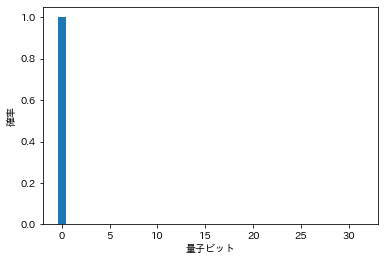

1回目
確率：0.06249999999999995


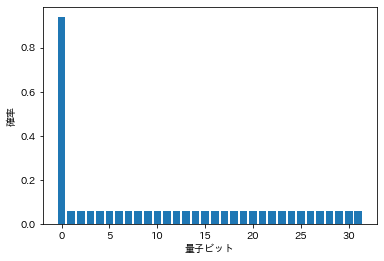

2回目
確率：0.11718749999999978


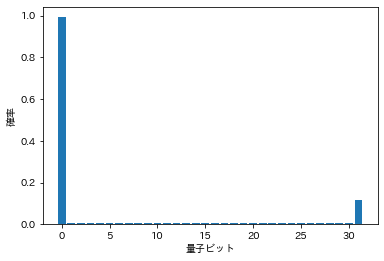

3回目
確率：0.15722656249999956


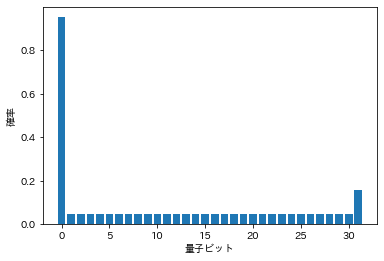

4回目
確率：0.17761230468749936


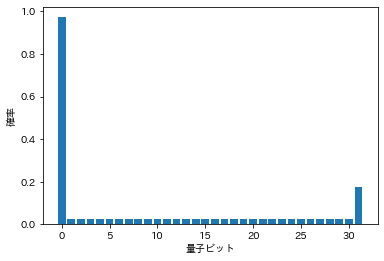

5回目
確率：0.17579650878906175


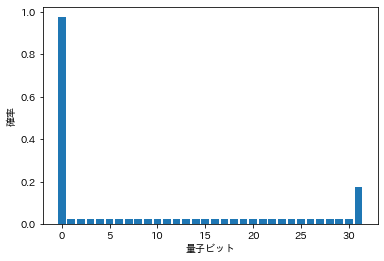

6回目
確率：0.15200614929199144


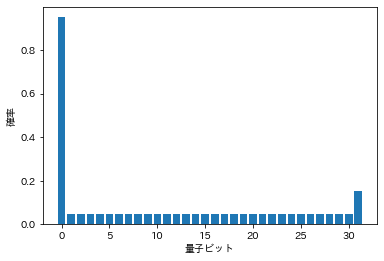

7回目
確率：0.10921502113342227


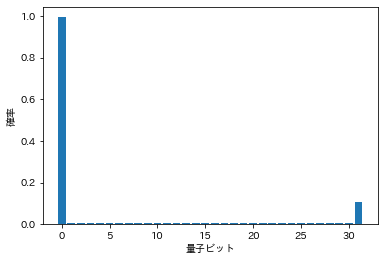

8回目
確率：0.052772015333175396


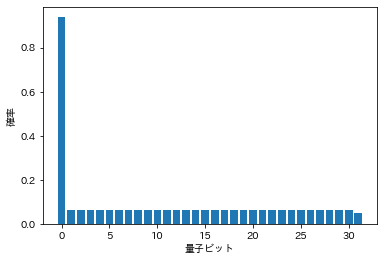

9回目
確率：0.010267492383718288


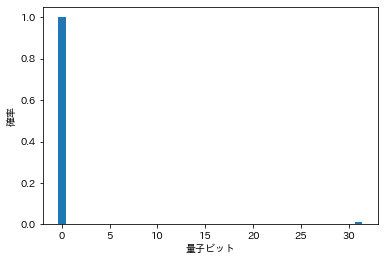

10回目
確率：0.0720235635526471


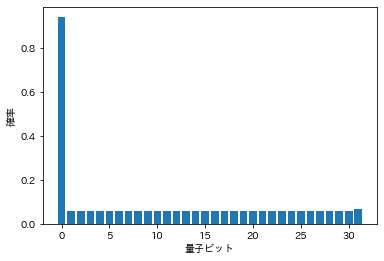

maximal probability 1.776123e-01 is obtained at k = 4


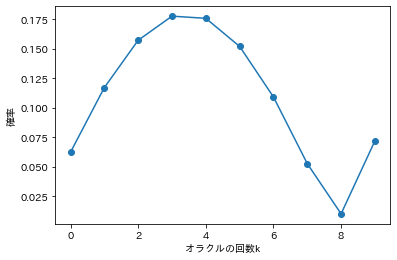

In [40]:
max_result = []
noisy_grover(nqubits,10, dephasing_rate)

ここでは$| 1 \cdots 1 \rangle$を解として設定しているので、$p = 0$だと31量子ビットに解が集まり、ほぼ確率1で解の状態を得ることができ、$p = 1$だと確率があまり上がらない。

確率p = 1でHadamardが作用されない
確率:0.0


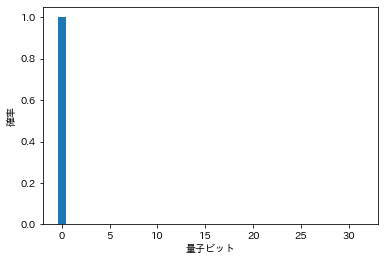

1回目
U_wを作用


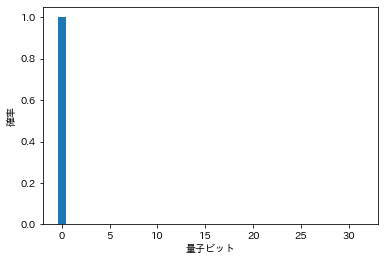

確率：0.06249999999999995


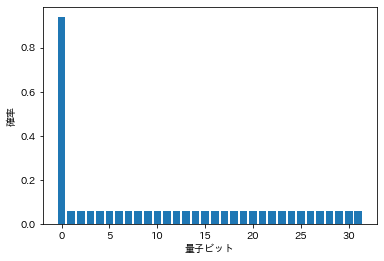

2回目
U_wを作用


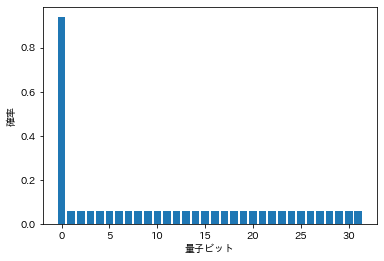

確率：0.11718749999999978


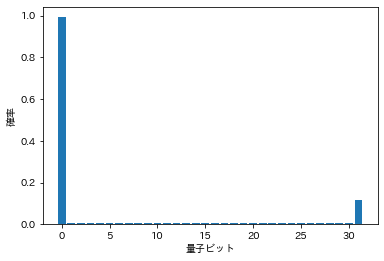

3回目
U_wを作用


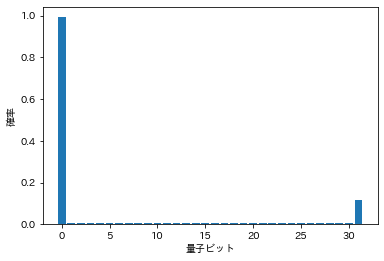

確率：0.15722656249999956


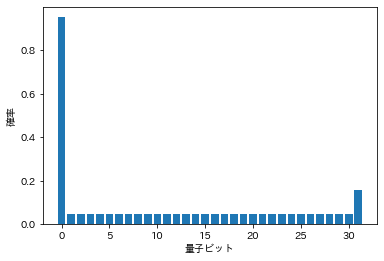

4回目
U_wを作用


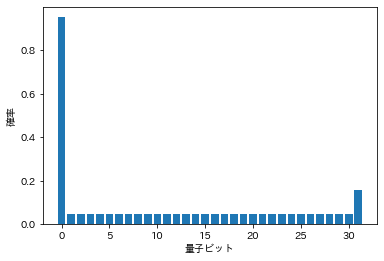

確率：0.17761230468749936


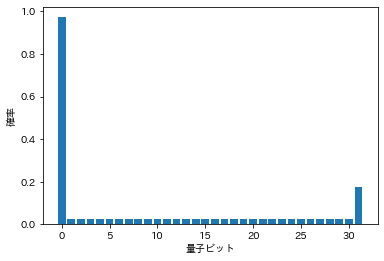

5回目
U_wを作用


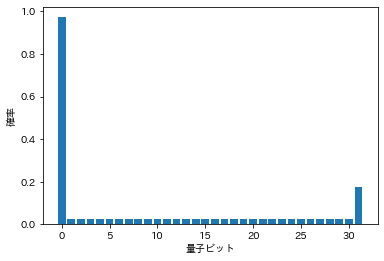

確率：0.17579650878906175


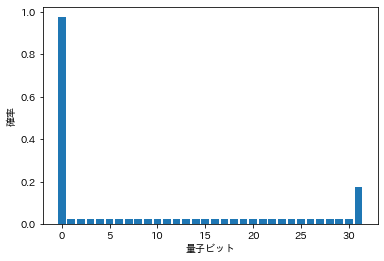

6回目
U_wを作用


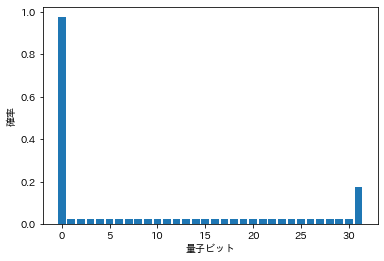

確率：0.15200614929199144


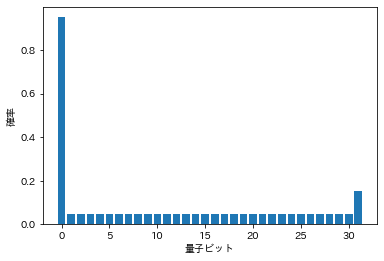

7回目
U_wを作用


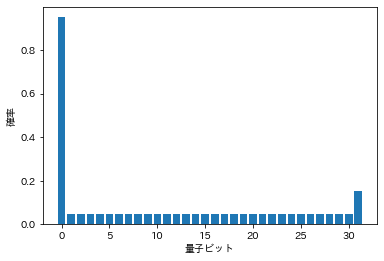

確率：0.10921502113342227


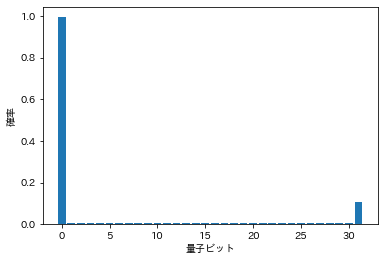

8回目
U_wを作用


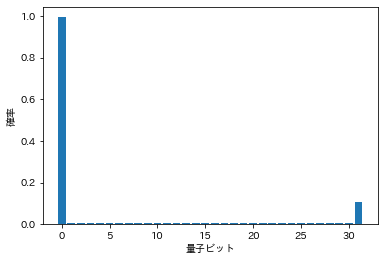

確率：0.052772015333175396


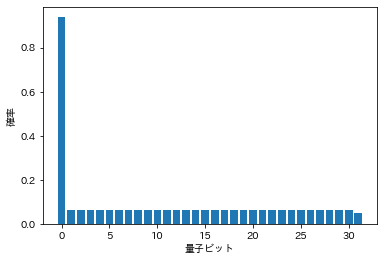

9回目
U_wを作用


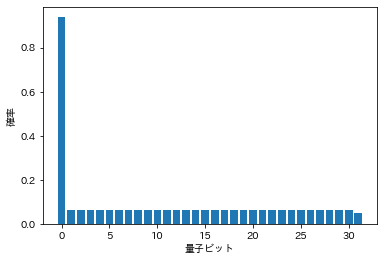

確率：0.010267492383718288


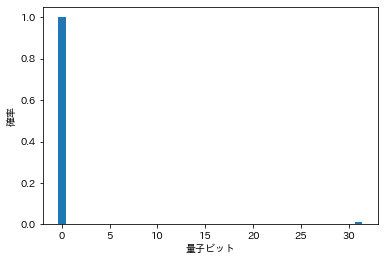

10回目
U_wを作用


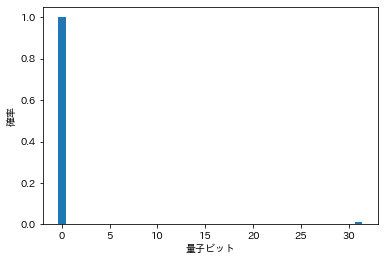

確率：0.0720235635526471


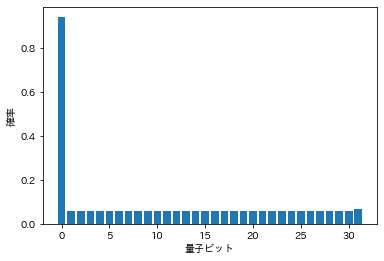

maximal probability 1.776123e-01 is obtained at k = 4


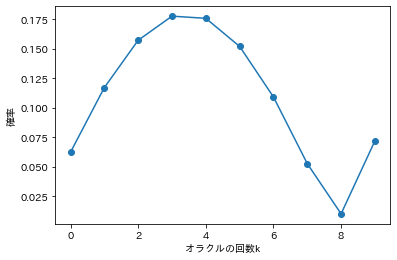

In [41]:
max_result = []
# グローバーのアルゴリズム
def noisy_grover(nqubits, operate_times, dephasing_rate):
    state = QuantumState(nqubits)
    state.set_zero_state()

    # 内積を評価するために 解状態 |1...1> を作っておく
    target_state = QuantumState(nqubits)
    target_state.set_computational_basis(2 ** nqubits - 1) # 2**n_qubits-1 は 2進数で 1...1

    # グローバーのアルゴリズムの実行
    Noisy_Hadamard = make_noisy_Hadamard(nqubits, dephasing_rate)
    U_w = make_U_w(nqubits)
    U_s = make_U_s(nqubits)

    result = []

    state = QuantumState(nqubits)
    state.set_zero_state()
    Noisy_Hadamard.update_quantum_state(state)
    print(f'確率p = {dephasing_rate}でHadamardが作用されない')
    print(f'確率:{np.linalg.norm(inner_product(state, target_state))}')
    show_distribution(state, nqubits)
    for k in range(operate_times):
        print(f'{k + 1}回目')
        U_w.update_quantum_state(state)
        print(f'U_wを作用')
        show_distribution(state, nqubits)
        U_s.update_quantum_state(state)
        fuga = np.linalg.norm(inner_product(state, target_state))
        print(f'確率：{fuga}')
        result.append(fuga)
        show_distribution(state, nqubits)


    max_k = np.argmax(result)
    max_result.append(result[max_k])

    print(f'maximal probability {result[max_k]:5e} is obtained at k = {max_k + 1}')

    plt.plot(result, "o-")
    plt.xlabel('オラクルの回数k')
    plt.ylabel('確率')

noisy_grover(nqubits,10, dephasing_rate)


#### 試行回数を増やしてみる

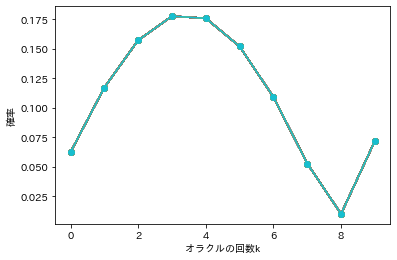

In [42]:
sample_data_times = 100 # サンプルを集める試行回数
nqubits = 5
total_result = []
for i in range(sample_data_times):
    noisy_grover_1(nqubits, 10, dephasing_rate)
    total_result.append(max_result)

# print(f'total result: {total_result}')

## p = 0.1, 0.2, 0.5, 0.9の時にどのようなことが発生するか

### p = 0.1の時

確率p = 0.1でHadamardが作用されない
確率:0.1767766952966368


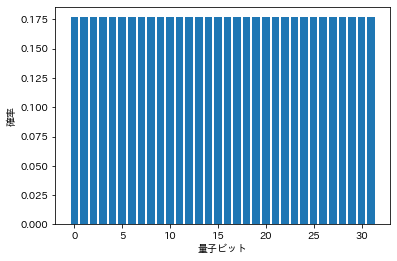

1回目
U_wを作用


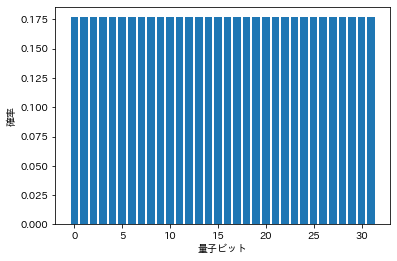

確率：0.5082329989778305


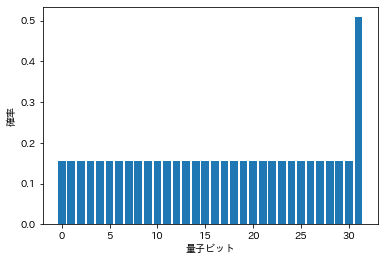

2回目
U_wを作用


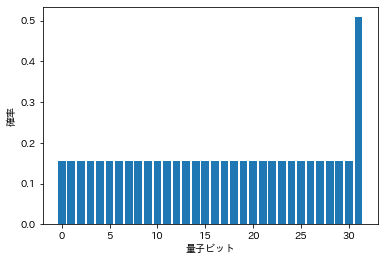

確率：0.7761601777867947


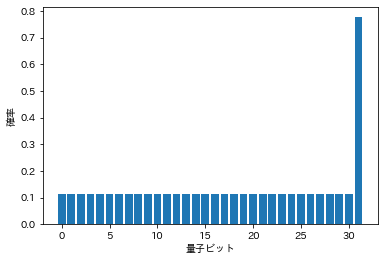

3回目
U_wを作用


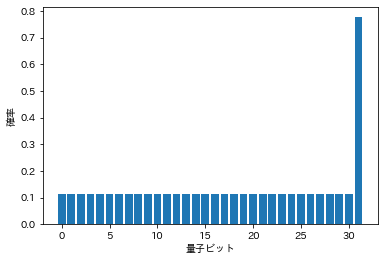

確率：0.9470673343724091


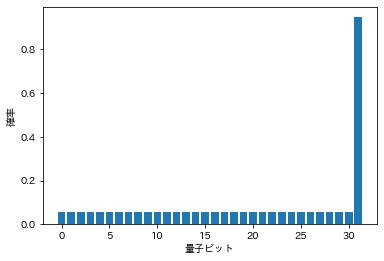

4回目
U_wを作用


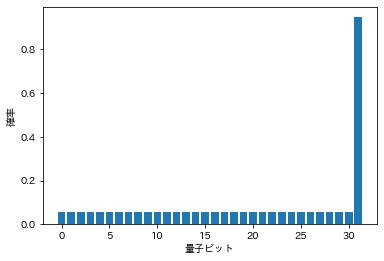

確率：0.9995910741614723


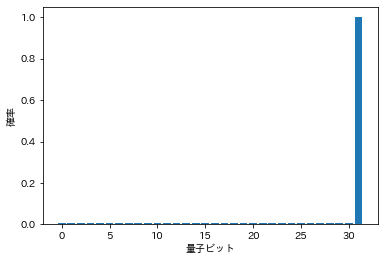

5回目
U_wを作用


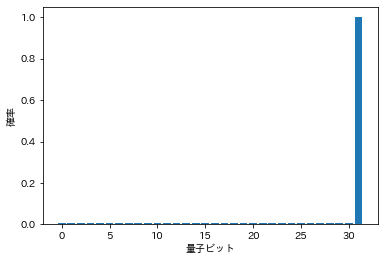

確率：0.9271659296803515


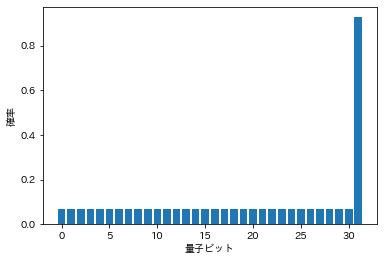

6回目
U_wを作用


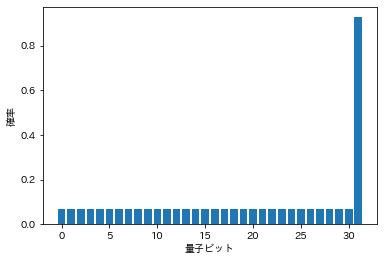

確率：0.738845043989187


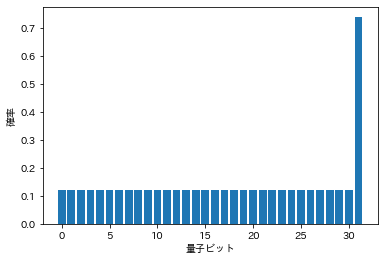

7回目
U_wを作用


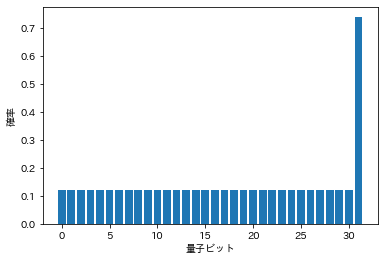

確率：0.4581685277993745


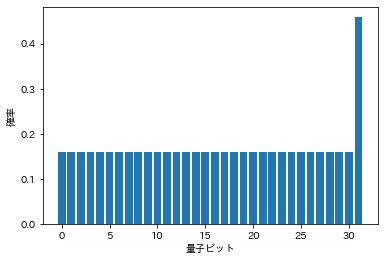

8回目
U_wを作用


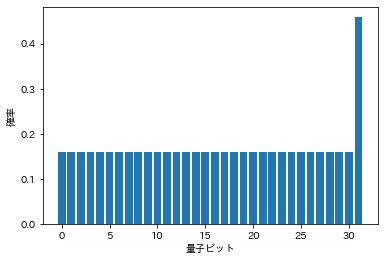

確率：0.1202209456346408


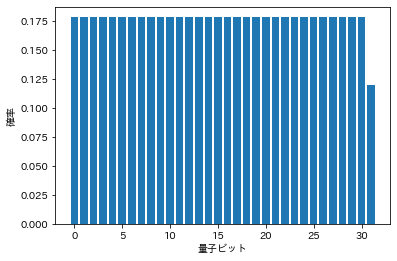

9回目
U_wを作用


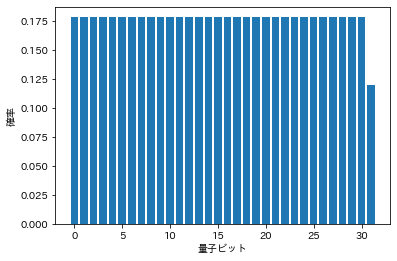

確率：0.23275425473442243


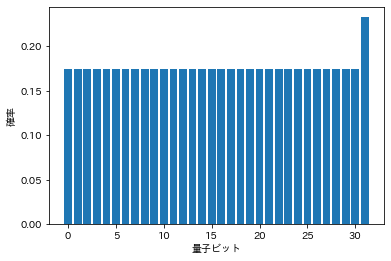

10回目
U_wを作用


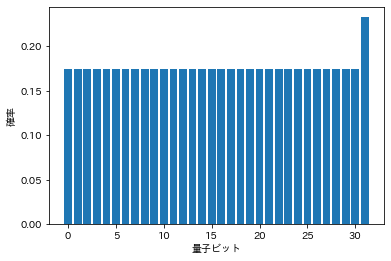

確率：0.5566351732616823


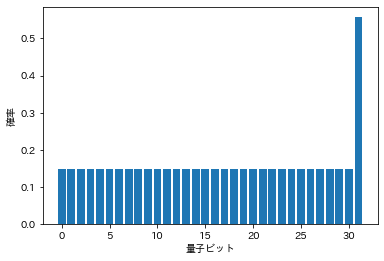

maximal probability 9.995911e-01 is obtained at k = 4


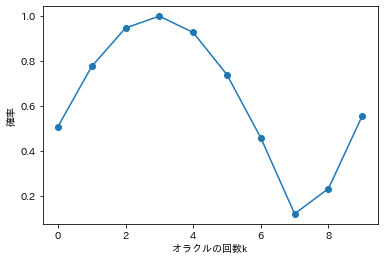

In [43]:
# dephasing_rate = 0.1
dephasing_rate = float(Fraction('0.1'))
noisy_grover(nqubits, 10, dephasing_rate)

#### 試行回数を増やす

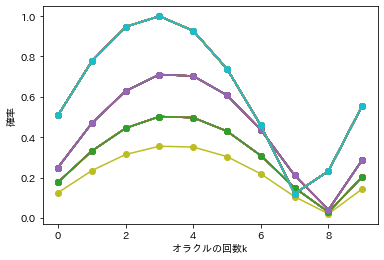

In [44]:
sample_data_times = 100 # サンプルを集める試行回数
nqubits = 5
total_result = []
for i in range(sample_data_times):
    max_result = []
    noisy_grover_1(nqubits, 10, dephasing_rate)
    total_result.append(max_result)

# print(f'total result: {total_result}')

### p = 0.2の時

確率p = 0.2でHadamardが作用されない
確率:0.0


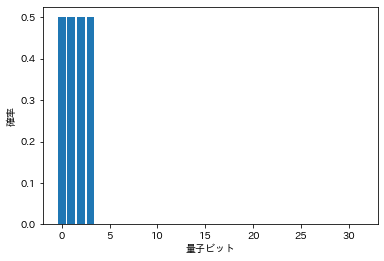

1回目
U_wを作用


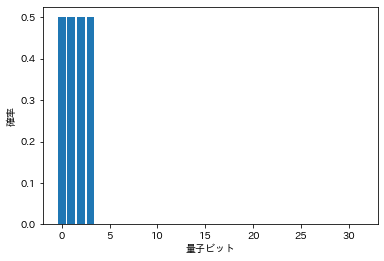

確率：0.12499999999999988


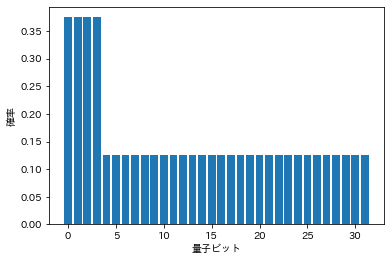

2回目
U_wを作用


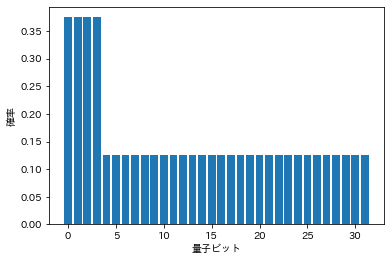

確率：0.23437499999999967


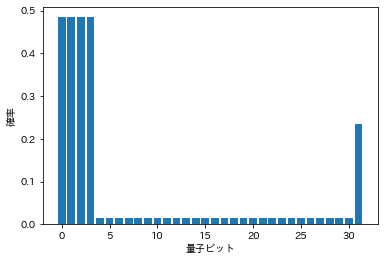

3回目
U_wを作用


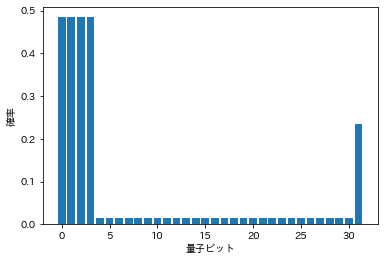

確率：0.3144531249999992


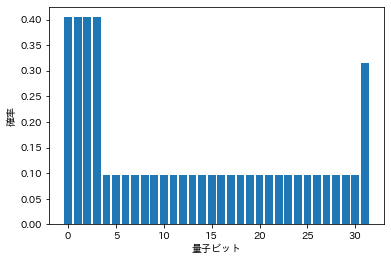

4回目
U_wを作用


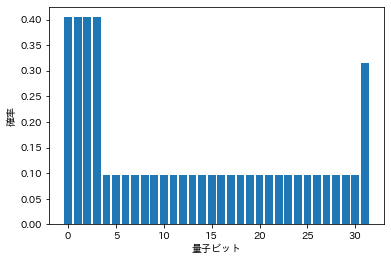

確率：0.3552246093749988


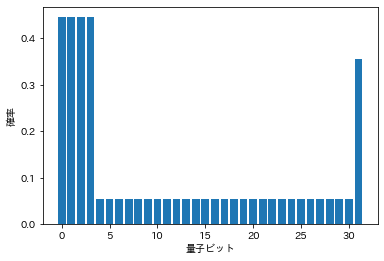

5回目
U_wを作用


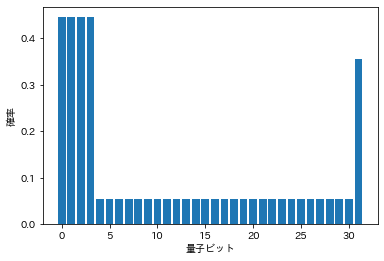

確率：0.3515930175781234


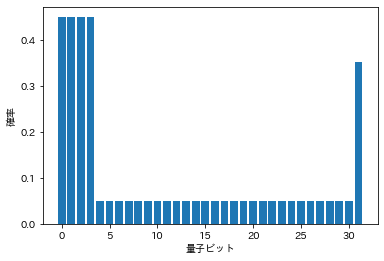

6回目
U_wを作用


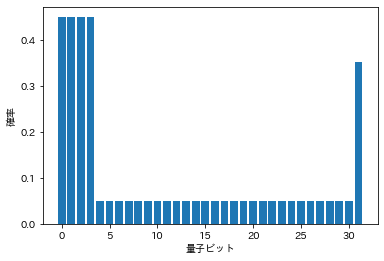

確率：0.30401229858398265


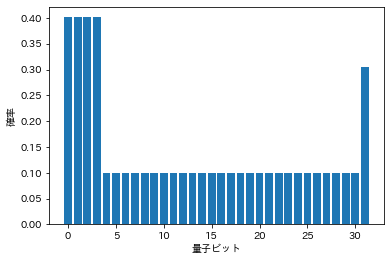

7回目
U_wを作用


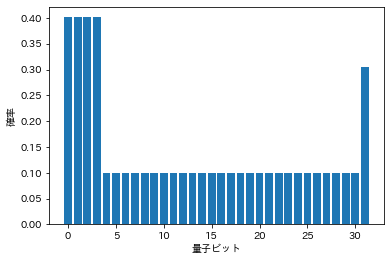

確率：0.21843004226684423


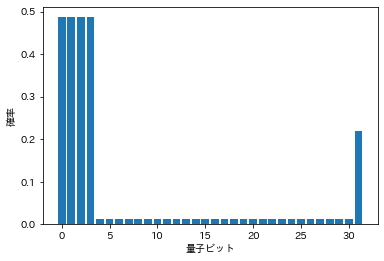

8回目
U_wを作用


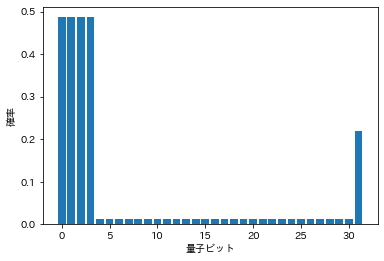

確率：0.10554403066635051


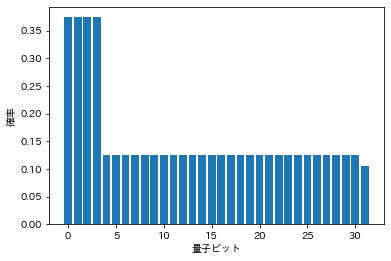

9回目
U_wを作用


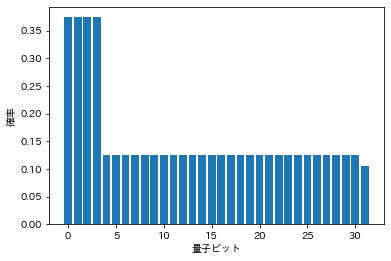

確率：0.020534984767436842


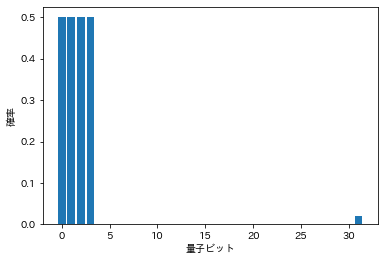

10回目
U_wを作用


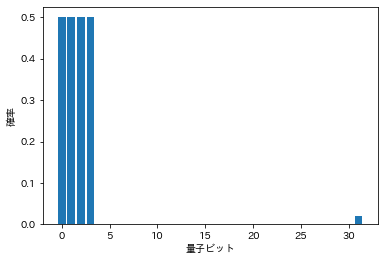

確率：0.14404712710529433


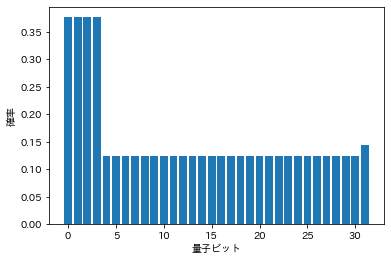

maximal probability 3.552246e-01 is obtained at k = 4


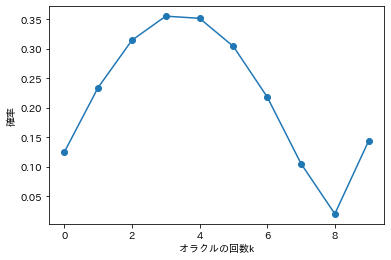

In [45]:
dephasing_rate = 0.2
noisy_grover(nqubits, 10, dephasing_rate)

#### 試行回数を増やす

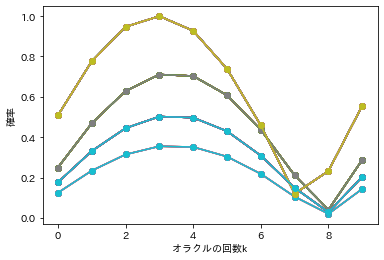

In [46]:
sample_data_times = 100 # サンプルを集める試行回数
nqubits = 5
total_result = []
for i in range(sample_data_times):
    max_result = []
    noisy_grover_1(nqubits, 10, dephasing_rate)
    total_result.append(max_result)

### p = 0.5 の時

確率p = 0.5でHadamardが作用されない
確率:0.0


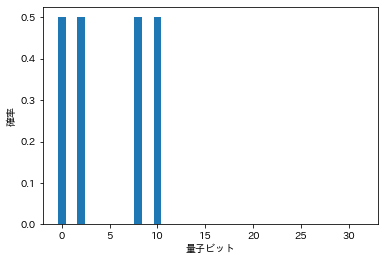

1回目
U_wを作用


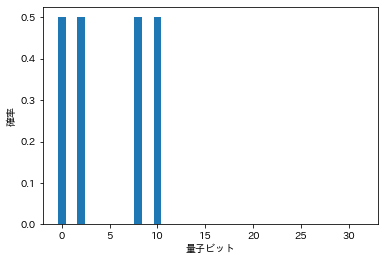

確率：0.12499999999999988


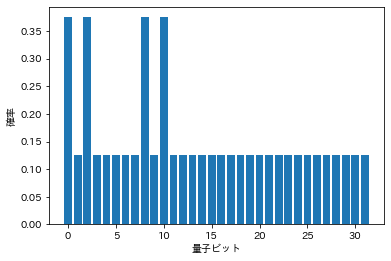

2回目
U_wを作用


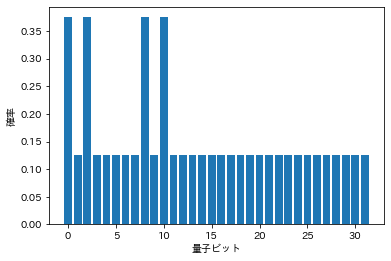

確率：0.23437499999999964


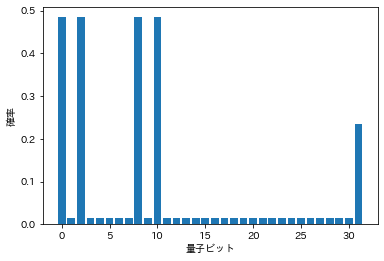

3回目
U_wを作用


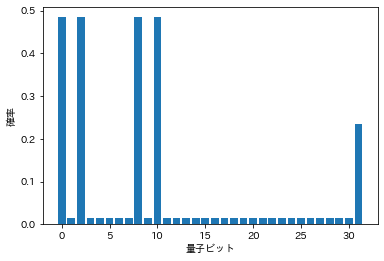

確率：0.3144531249999992


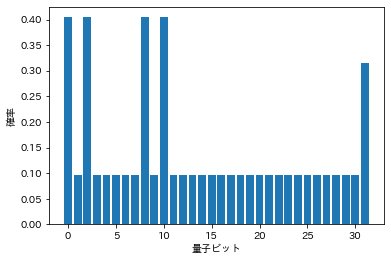

4回目
U_wを作用


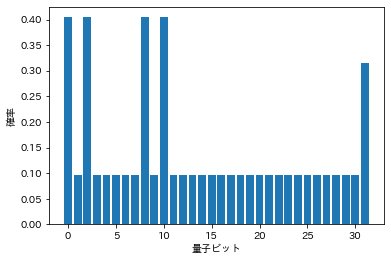

確率：0.3552246093749987


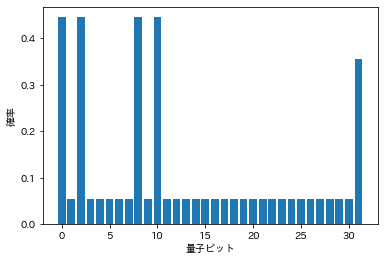

5回目
U_wを作用


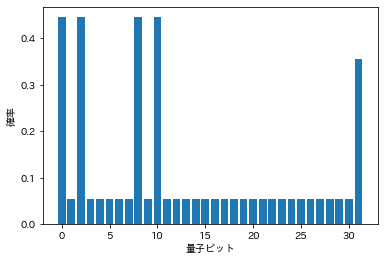

確率：0.3515930175781234


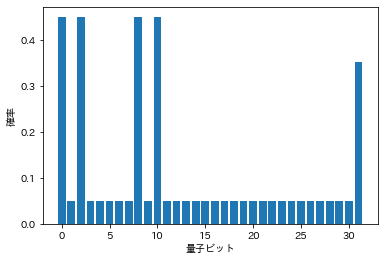

6回目
U_wを作用


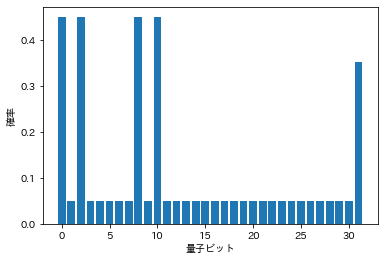

確率：0.30401229858398277


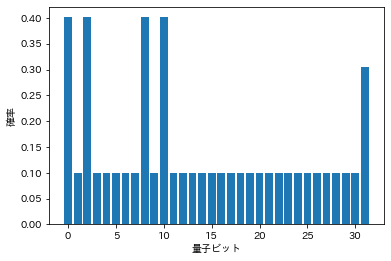

7回目
U_wを作用


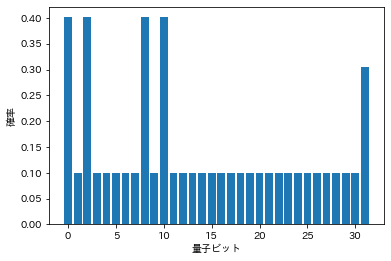

確率：0.21843004226684437


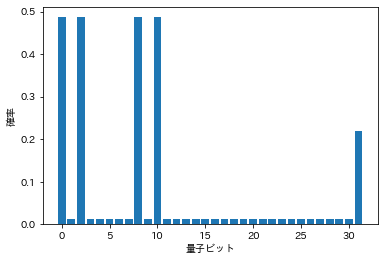

8回目
U_wを作用


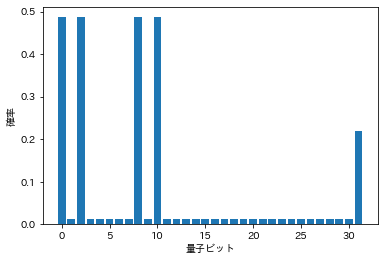

確率：0.10554403066635061


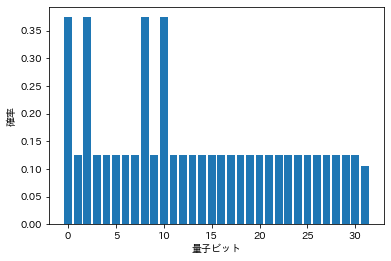

9回目
U_wを作用


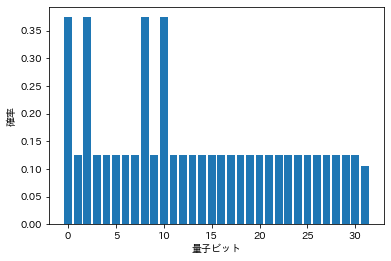

確率：0.020534984767436718


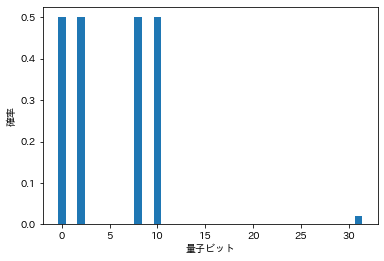

10回目
U_wを作用


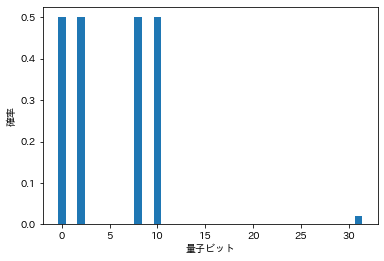

確率：0.14404712710529427


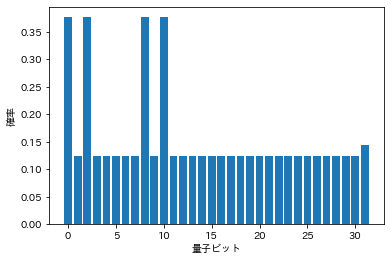

maximal probability 3.552246e-01 is obtained at k = 4


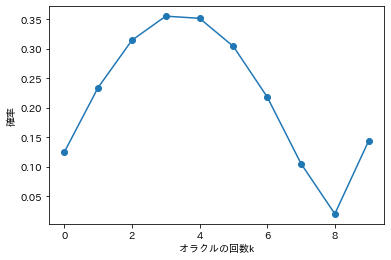

In [47]:
dephasing_rate = 0.5
noisy_grover(nqubits, 10, dephasing_rate)

#### 試行回数を増やしてみる

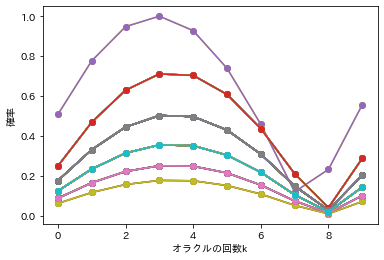

In [48]:
sample_data_times = 100 # サンプルを集める試行回数
nqubits = 5
total_result = []
for i in range(sample_data_times):
    max_result = []
    noisy_grover_1(nqubits, 10, dephasing_rate)
    total_result.append(max_result)


### p = 0.9の時

確率p = 0.9でHadamardが作用されない
確率:0.0


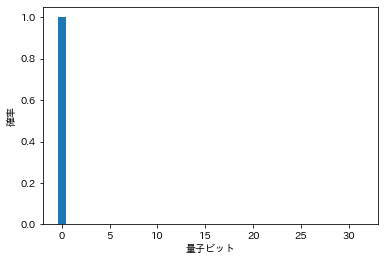

1回目
U_wを作用


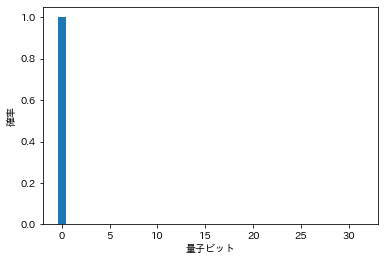

確率：0.06249999999999995


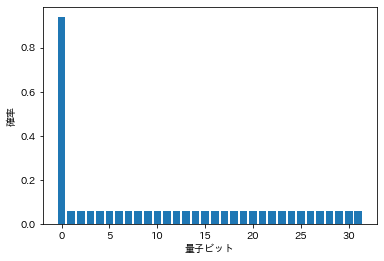

2回目
U_wを作用


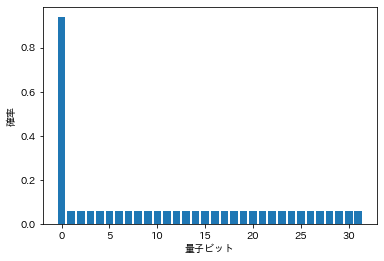

確率：0.11718749999999978


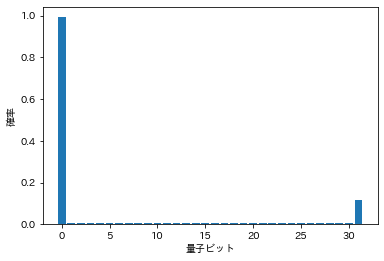

3回目
U_wを作用


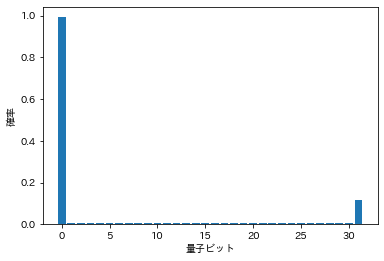

確率：0.15722656249999956


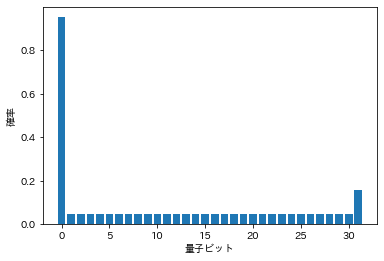

4回目
U_wを作用


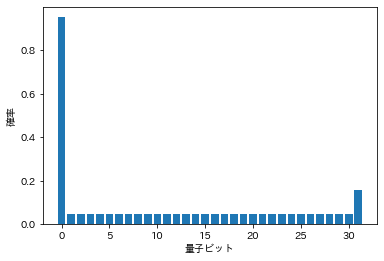

確率：0.17761230468749936


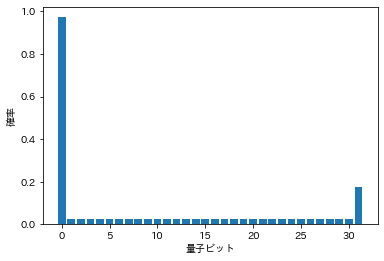

5回目
U_wを作用


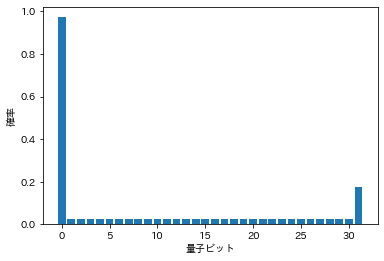

確率：0.17579650878906175


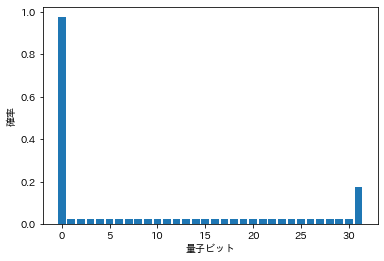

6回目
U_wを作用


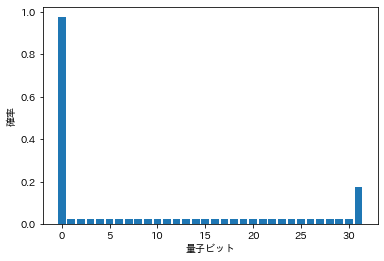

確率：0.15200614929199144


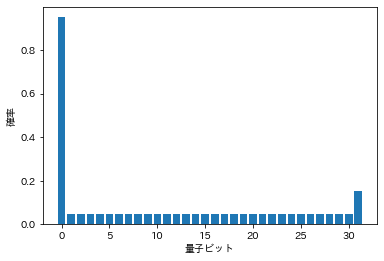

7回目
U_wを作用


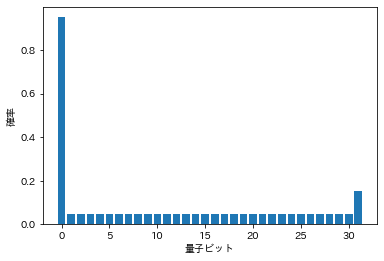

確率：0.10921502113342227


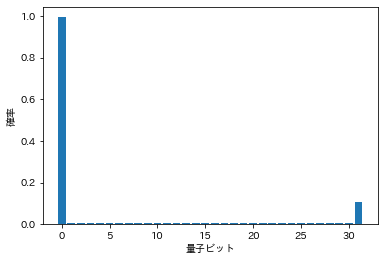

8回目
U_wを作用


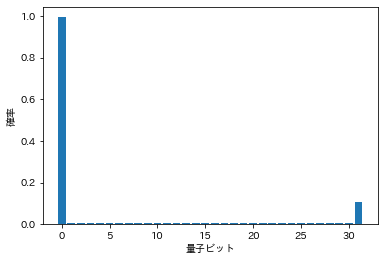

確率：0.052772015333175396


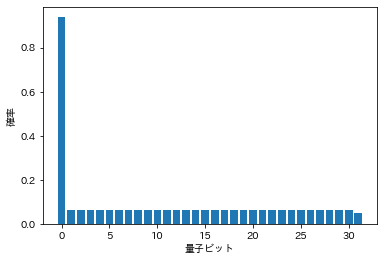

9回目
U_wを作用


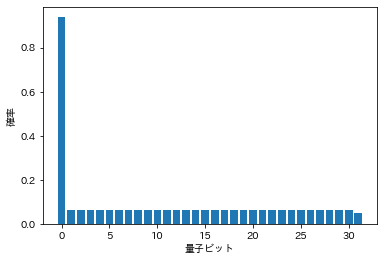

確率：0.010267492383718288


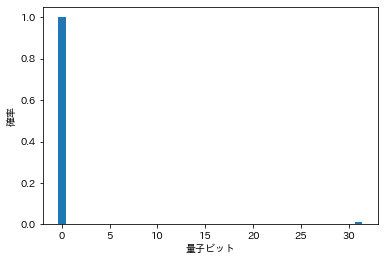

10回目
U_wを作用


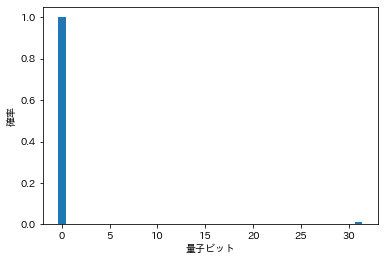

確率：0.0720235635526471


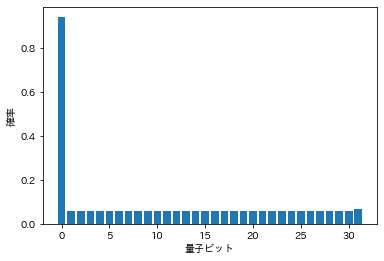

maximal probability 1.776123e-01 is obtained at k = 4


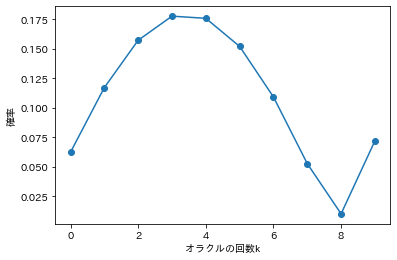

In [49]:
dephasing_rate = 0.9
noisy_grover(nqubits, 10, dephasing_rate)

#### 試行回数を増やしてみる

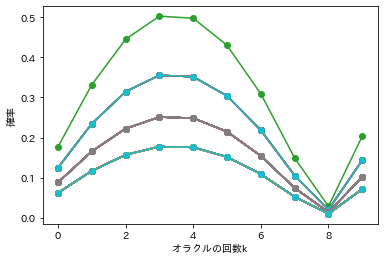

In [50]:
sample_data_times = 100 # サンプルを集める試行回数
nqubits = 5
total_result = []
for i in range(sample_data_times):
    max_result = []
    noisy_grover_1(nqubits, 10, dephasing_rate)
    total_result.append(max_result)

